# Airbnb New User Bookings
*Where will a new guest book their first travel experience?*

* [Kaggle Page](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings)

**Outline**

* [Read Data](#read)
* [Data Summary](#data check)
* [Exploratory Data Analysis](#eda)
* [Feature Creation and Preprocessing](#preprocess)
* [Model and Score](#model) 
* [Predicition](#predict)
* [Reference](#reference)

In [88]:
#%load_ext watermark

In [12]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import math

In [90]:
#%watermark -a 'PredictiveII' -d -t -v -p pandas,numpy,sklearn,watermark

---

## <a id="read">Read Data</a>

In [5]:
def data_reader():
    """
    read data into notebook 
    """
        
    data_dir = os.path.join('..', 'data') #/Users/siliangchen/Airbnb

    session_path = os.path.join(data_dir, 'sessions.csv')
    train_path = os.path.join(data_dir, 'train_users_2.csv')    
    test_path = os.path.join(data_dir, 'test_users.csv')   
    age_gender_bkt_path = os.path.join(data_dir, 'age_gender_bkts.csv')   
    country_path = os.path.join(data_dir, 'countries.csv')   
    sample_submission_path = os.path.join(data_dir, 'sample_submission_NDF.csv')   

    session = pd.read_csv(session_path)
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    age_gender = pd.read_csv(age_gender_bkt_path)
    country = pd.read_csv(country_path)
    sample_submission = pd.read_csv(sample_submission_path)

    
    return session, train, test, age_gender, country, sample_submission

In [16]:
session, train, test, age_gender, country, sample_submission = data_reader()

## <a id="data check">Data Summary</a>

### Data dictionary:
** Table 1. Session: web sessions log for users (can be joined with tables for additional feature extraction)**
* **user_id**: to be joined with the column 'id' in users table
* **action**
* **action_type**
* **action_detail**
* **device_type**
* **secs_elapsed**

** Table 2. Train user: the training set of users**
* **id**: user id
* **date_account_created**: the date of account creation
* **timestamp_first_active**: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up.
* **date_first_booking**: date of first booking
* **gender**
* **age**
* **signup_method**
* **signup_flow**: the page a user came to signup up from
* **language**: international language preference
* **affiliate_channel**: what kind of paid marketing
* **affiliate_provider**: where the marketing is e.g. google, craigslist, other
* **first_affiliate_tracked**: whats the first marketing the user interacted with before the signing up
* **signup_app**
* **first_device_type**
* **first_browser**
* **country_destination**: this is the target variable you are to predict

** Table 3. age_gender: summary statistics of users' age group, gender, country of destination **

** Table 4. country: summary statistics of destination countries in this dataset and their locations **

** Table 5. test user: the testing set of users **

### Data clean and feature engineering:
### Session
1. missing data (34496 user_id = NaN, 0.3% of total rows, dropped and saved a session_v1)
2. added features based on time spent and actions
3. rollup data and extract features

In [147]:
#Data overview
unique_user_count = len(set(session["user_id"])) #135484 unique users in session
print(session.shape)
session.head(2)
null_userid = session[pd.isnull(session["user_id"])]
len(null_userid) #can't use these consecutive null user ids link information, drop these user IDs

#drop rows where userid is null
session_v1 = session.dropna(axis = 0, subset = ["user_id"])
print(session_v1.shape)

(10567737, 7)
(10533241, 7)


In [148]:
session_v1.tail(3)
session_v1["device_type"].value_counts()
session_v1["action_type"].value_counts()

view                3549375
data                2096655
click               1990058
-unknown-           1028251
submit               620063
message_post          86925
partner_callback      19053
booking_request       18762
modify                 1138
booking_response          4
Name: action_type, dtype: int64

In [150]:
#Feature creation
def add_features(group):
    group["obs_count"] = group.user_id.count()
    group["action_count"] = group.action.nunique()
    group["total_secs_elapsed"] = group.secs_elapsed.sum()
    group["avg time"] = group["total_secs_elapsed"]/group["obs_count"]
    group["unique_device"] = group.device_type.nunique()
    return group

session_v2 = session_v1.groupby(['user_id']).apply(add_features)

In [151]:
session_v2.head(127)

,user_id,action,action_type,action_detail,device_type,secs_elapsed,total_secs_elapsed,obs_count,action_count,avg time,unique_device
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0,3427210.0,126,16,27200.079365,2
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0,3427210.0,126,16,27200.079365,2
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0,3427210.0,126,16,27200.079365,2
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0,3427210.0,126,16,27200.079365,2
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0,3427210.0,126,16,27200.079365,2
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0,3427210.0,126,16,27200.079365,2
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0,3427210.0,126,16,27200.079365,2
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0,3427210.0,126,16,27200.079365,2
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0,3427210.0,126,16,27200.079365,2
10,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,59274.0,3427210.0,126,16,27200.079365,2


### Train
1. max(age) = 2014 is obvriously wrong, need to check on age column and recompute
2. many columns have missing information that need to be taken care of
2. lots of gender unknown

In [77]:
#check each row has a unique user id
print(train.shape)
unique_user_count = len(set(train["id"]))
print(unique_user_count)

#check summary stats
train.head(5)
train.describe(include = "all") #many cols have missing information

(213451, 16)
213451


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,213451,213451,2.134510e+05,88908,213451,125461.000000,213451,213451.000000,213451,213451,213451,207386,213451,213451,213451,213451
unique,213451,1634,NaN,1976,4,NaN,3,NaN,25,8,18,7,4,9,52,12
top,nceap058zs,2014-05-13,NaN,2014-05-22,-unknown-,NaN,basic,NaN,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,1,674,NaN,248,95688,NaN,152897,NaN,206314,137727,137426,109232,182717,89600,63845,124543
mean,NaN,NaN,2.013085e+13,NaN,NaN,49.668335,NaN,3.267387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,9.253717e+09,NaN,NaN,155.666612,NaN,7.637707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2.009032e+13,NaN,NaN,1.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.012123e+13,NaN,NaN,28.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2.013091e+13,NaN,NaN,34.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2.014031e+13,NaN,NaN,43.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
#age distribution
print(train.age.describe())
print(len(train[train["age"]>90])) #jc: 1.2% of age above 90, drop these? team decision
train[train["age"]>90]

#train['date_first_booking']

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64
2543


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,-unknown-,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
398,9ouah6tc30,2010-04-12,20100412231534,2010-04-12,FEMALE,104.0,facebook,3,en,other,craigslist,linked,Web,iPhone,Mobile Safari,FR
627,dc3udjfdij,2010-05-19,20100519012455,2010-06-16,-unknown-,105.0,basic,2,en,other,craigslist,omg,Web,Mac Desktop,Safari,FR
645,ixv5186g1h,2010-05-21,20100521070029,NaN,MALE,95.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
777,kqf8b3ta98,2010-06-07,20100607184626,NaN,FEMALE,94.0,basic,0,en,content,google,linked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
1190,qc9se9qucz,2010-07-27,20100727002029,2010-07-27,-unknown-,105.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Firefox,US
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [17]:
train[train.age>1000].age.value_counts()

2014.0    710
2013.0     39
1932.0      3
1931.0      3
1949.0      3
1924.0      2
1936.0      2
1947.0      2
1929.0      2
1928.0      2
1952.0      1
1938.0      1
1933.0      1
1927.0      1
1942.0      1
1995.0      1
2008.0      1
1953.0      1
1926.0      1
1925.0      1
1935.0      1
Name: age, dtype: int64

In [18]:
train[(train.age>90) & (train.age<1000)].age.value_counts()

105.0    1131
110.0     196
95.0       49
104.0      48
102.0      34
109.0      31
100.0      26
103.0      26
96.0       25
101.0      23
107.0      23
93.0       18
99.0       17
106.0      17
98.0       15
108.0      15
92.0       14
115.0      13
91.0       12
94.0       12
97.0       10
113.0       4
111.0       2
112.0       1
150.0       1
132.0       1
Name: age, dtype: int64

In [20]:
train[(train.age<15)].age.value_counts()

5.0    45
2.0     7
4.0     3
1.0     2
Name: age, dtype: int64

In [22]:
def ageTransform(age):
    """
    Replace strange ages
    """
    current_year = 2014
    if (age>2000):
        new_age = 34 #replace it with median
    elif (age>1000):
        new_age = 2014-age+1
    elif (age>100):
        new_age = 90 
    elif (age<10):
        new_age = 34 #replace it with median
    elif (math.isnan(age)):
        new_age = 34 #replace it with median
    else:
        new_age = age                    

    return new_age   

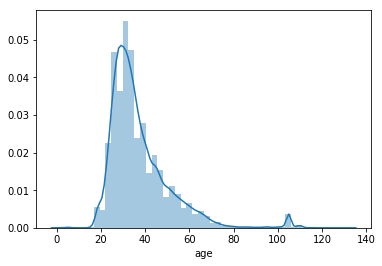

In [23]:
# Original Age Distribution
train_age = train[(train.age.notnull()) & (train.age<150)]
sn.distplot(train_age['age'])

In [24]:
train['age'] = train['age'].apply(lambda x: ageTransform(x))

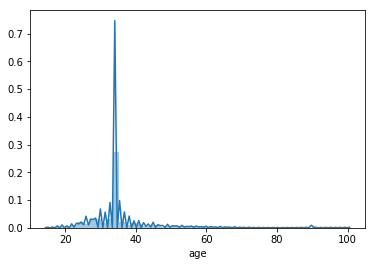

In [25]:
# New Age Distribution, replace lots of NaN's with median, which is 34.
sn.distplot(train['age'])

In [26]:
train.age.describe()

count    213451.000000
mean         35.892186
std          10.113310
min          15.000000
25%          32.000000
50%          34.000000
75%          35.000000
max         100.000000
Name: age, dtype: float64

### Age_gender

In [47]:
age_gender.shape
age_gender.head(5)
#set(age_gender["year"])

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


summary statistics of users' age group, gender, country of destination

## country

correct format for submitting your predictions

In [29]:
country.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


### Test

In [ ]:
#merge sessions with test data
pd.merge(test, sessions, how=left)

In [43]:
test.head()
min(test['date_account_created'])

nan